In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

# some custom libraries!
import sys
sys.path.append("..")
from ds_utils.decision_surface import *

## From Last Time: Cross validation

One of the limitations of model evaluation with a traditional train/test split is "data loss". We set aside (say) 20% of our data for evaluation and *never* used it for training. We also never used the 80% of the data set aside for training to test generalizability.  Although this is far better than testing on the training data, which does not measure generalization performance at all, there are a number of potential problems with the simple holdout approach.

1) Perhaps the random split was particularly bad (or good).  Do we have any confidence in our accuracy estimate?

2) We are using only 20% of the data for testing.  Could we possibly use the data more fully for testing?

3) Often we want to know something about the distribution of our evaluation metrics. A simple train/test split only allows a single "point estimate"

Instead of only making the split once, let's use "cross-validation" -- every record will contribute to testing as well as to training.


<img src="images/cross.png" alt="Drawing" style="width: 600px;"/>

## Hyper-Parameter Tuning

As seen previously, most models have a number of settings that impact their behavior and therefore generalization performance. One common use of cross-validation is to tune these "hyper-parameters" (so-called because the coefficients in a model are usually called parameters). One can select several values for a particular hyper-parameter, use cross-validation to estimate model generalization performance, and keep the model that offered the best results.

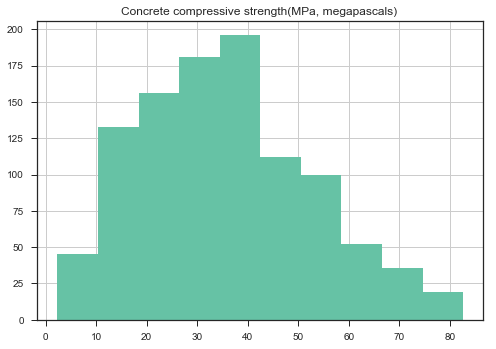

In [2]:
concrete_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"

concrete_df = pd.read_excel(concrete_url).dropna()
concrete_df.head(5)

concrete_df[["Concrete compressive strength(MPa, megapascals) "]].hist()
plt.show()

Let's make this into a binary classification problem.

In [3]:
compression_median = concrete_df["Concrete compressive strength(MPa, megapascals) "].median()
concrete_df["class"] = concrete_df["Concrete compressive strength(MPa, megapascals) "].apply(
        lambda strength: 1 if strength > compression_median else 0
    )
concrete_df.columns

Index([            u'Cement (component 1)(kg in a m^3 mixture)',
       u'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
                  u'Fly Ash (component 3)(kg in a m^3 mixture)',
                   u'Water  (component 4)(kg in a m^3 mixture)',
         u'Superplasticizer (component 5)(kg in a m^3 mixture)',
        u'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
           u'Fine Aggregate (component 7)(kg in a m^3 mixture)',
                                                   u'Age (day)',
            u'Concrete compressive strength(MPa, megapascals) ',
                                                       u'class'],
      dtype='object')

In [4]:
concrete_df.rename(columns={
    "Cement (component 1)(kg in a m^3 mixture)"             : "Cement",
    "Blast Furnace Slag (component 2)(kg in a m^3 mixture)" : "Slag",
    "Fly Ash (component 3)(kg in a m^3 mixture)"            : "Fly Ash",
    "Water  (component 4)(kg in a m^3 mixture)"             : "Water",
    "Superplasticizer (component 5)(kg in a m^3 mixture)"   : "Superplasticizer",
    "Coarse Aggregate  (component 6)(kg in a m^3 mixture)"  : "Coarse Agg",
    "Fine Aggregate (component 7)(kg in a m^3 mixture)"     : "Fine Agg",
    "Age (day)"                                             : "Age",
    "Concrete compressive strength(MPa, megapascals) "      : "Strength"
}, inplace= True)

In [5]:
predictor_columns = [c for c in concrete_df.columns if c != "Strength" and c != "class"]
predictor_columns

['Cement',
 'Slag',
 'Fly Ash',
 'Water',
 'Superplasticizer',
 'Coarse Agg',
 'Fine Agg',
 'Age']

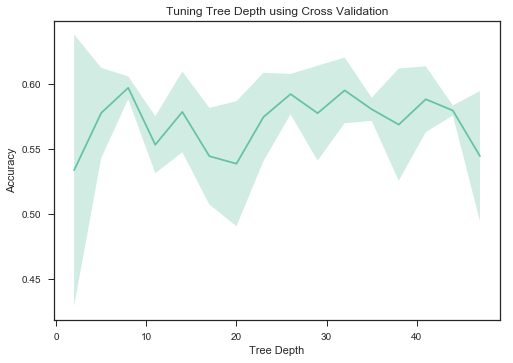

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

def score_model(model, df, predictor_columns, class_column, scoring="accuracy"):
    scores = cross_val_score(model, df[predictor_columns], df[class_column], scoring=scoring)
    return {"mean": scores.mean(), "std_dev": scores.std()}

depths = list(range(2, 50, 3))
scores_list = [score_model(DecisionTreeClassifier(max_depth=depth),
                           concrete_df,
                           predictor_columns,
                           "class")
               for depth in depths]

accys = np.array([score["mean"] for score in scores_list])
accys_std = np.array([score["std_dev"] for score in scores_list])

plt.plot(depths, accys)
plt.fill_between(depths, accys + accys_std, accys - accys_std, alpha=0.3)
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Tuning Tree Depth using Cross Validation")
plt.show()

## Grid Search: Using Cross-Validation to Tune Many Hyper-Parameters

The concept explored above can be extended in a very natural way to simultaniuosly optimize many hyper-parameters using a technique called "grid search". One first defines a "grid", of hyper-parameter values to explore. The grid search explores all possible combinations of these settings, selecting the setting with the best cross-validated value of the chosen generalization measure.

Sklearn provides a convenient implementation.

In [7]:
from sklearn.model_selection import GridSearchCV

grid = {
    "max_depth": list(range(2, 53, 5)),
    "min_samples_leaf": list(range(2, 53, 5))
}

# gridsearchcv behaves just like a model, with fit and predict, with some additional
# functionality too
tuned_model = GridSearchCV(DecisionTreeClassifier(), grid, scoring="accuracy")
tuned_model.fit(concrete_df[predictor_columns], concrete_df["class"])

print ("Best accuracy: %0.3f, using: " % tuned_model.best_score_)
print (tuned_model.best_params_)

Best accuracy: 0.635, using: 
{'max_depth': 7, 'min_samples_leaf': 42}


Let's take a look at the performance over our parameter grid.

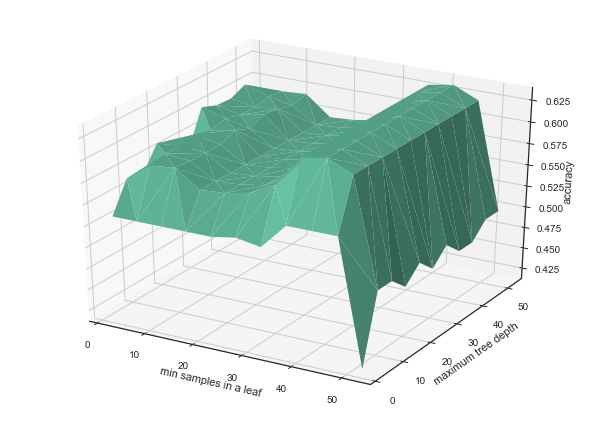

In [8]:
from mpl_toolkits.mplot3d import Axes3D

means = tuned_model.cv_results_['mean_test_score']
stds = tuned_model.cv_results_['std_test_score']
params = tuned_model.cv_results_['params']

min_samples_leafs = [param["min_samples_leaf"] for param in params]
max_depths = [param["max_depth"] for param in params]

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(min_samples_leafs, max_depths, means, linewidth=0.1)
ax.set_xlabel('min samples in a leaf')
ax.set_ylabel('maximum tree depth')
ax.set_zlabel('accuracy')

plt.show()

Care must be taken when performing grid search: grids with many potential values combined with slow-ish model training can really blow up the time it takes to tune a model!

In [9]:
from sklearn.ensemble import RandomForestClassifier

grid = {
    "n_estimators": list(range(1, 100, 10)),
    "min_samples_leaf": list(range(2, 200, 20)),
    "criterion": ["entropy", "gini"]
}

# increased verbosity
rf_tuned_model = GridSearchCV(RandomForestClassifier(), grid, scoring="accuracy", verbose=1)
rf_tuned_model.fit(concrete_df[predictor_columns], concrete_df["class"])

print ("Best accuracy: %0.3f, using: " % rf_tuned_model.best_score_)
print (rf_tuned_model.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best accuracy: 0.699, using: 
{'n_estimators': 1, 'criterion': 'gini', 'min_samples_leaf': 102}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.4min finished


Note that all the hyper-parameters tuned above are used to control complexity. This will nearly always be the case when optimizing a ML model-- getting the best generalization performance out of one's model means balancing the tension between allowing a model to fit fine-grained patterns to the data (a good thing), and the tendancy to fit idiosyncracies in a particular data set-- things that don't generalize (a bad thing). 

## Complexity control for logistic regression (regularization)

Recall that when fitting a logistic regression classifier, we try to find the set of weights, $\textbf{w}$, that maximize the fit to the data, based on some fit (objective) function. In this case, let's call our objective function $g()$, which means that we want $\arg\max_\textbf{w} g(\textbf{x}, \textbf{w})$.

Since we are trying to find the set of weight without too much complexity, when we perform **regularization** we **penalize** our fit as it gets more complex.  This is achieved by adding a "penalty term" into the objective function, and using a "regularization parameter" $\lambda$ (also sometimes represented as `c`, which is usually $\frac{1}{\lambda}$ so smaller values of `c` lead to larger complexity penalties) to specify how much importance our optimization procedure should place on the fit vs. the penalty:

$\arg\max_\textbf{w} g(\textbf{x}, \textbf{w}) - \lambda \cdot \text{penalty}(\textbf{w})$.

The two most common type of regularization in logistic regression are the so-called $L_1$ and $L_2$ regularizations, which simply use the sum of the weights (w) and the sum of the squares of the weights, respectively, as the penalty.


Fitting with l2 regularization: 



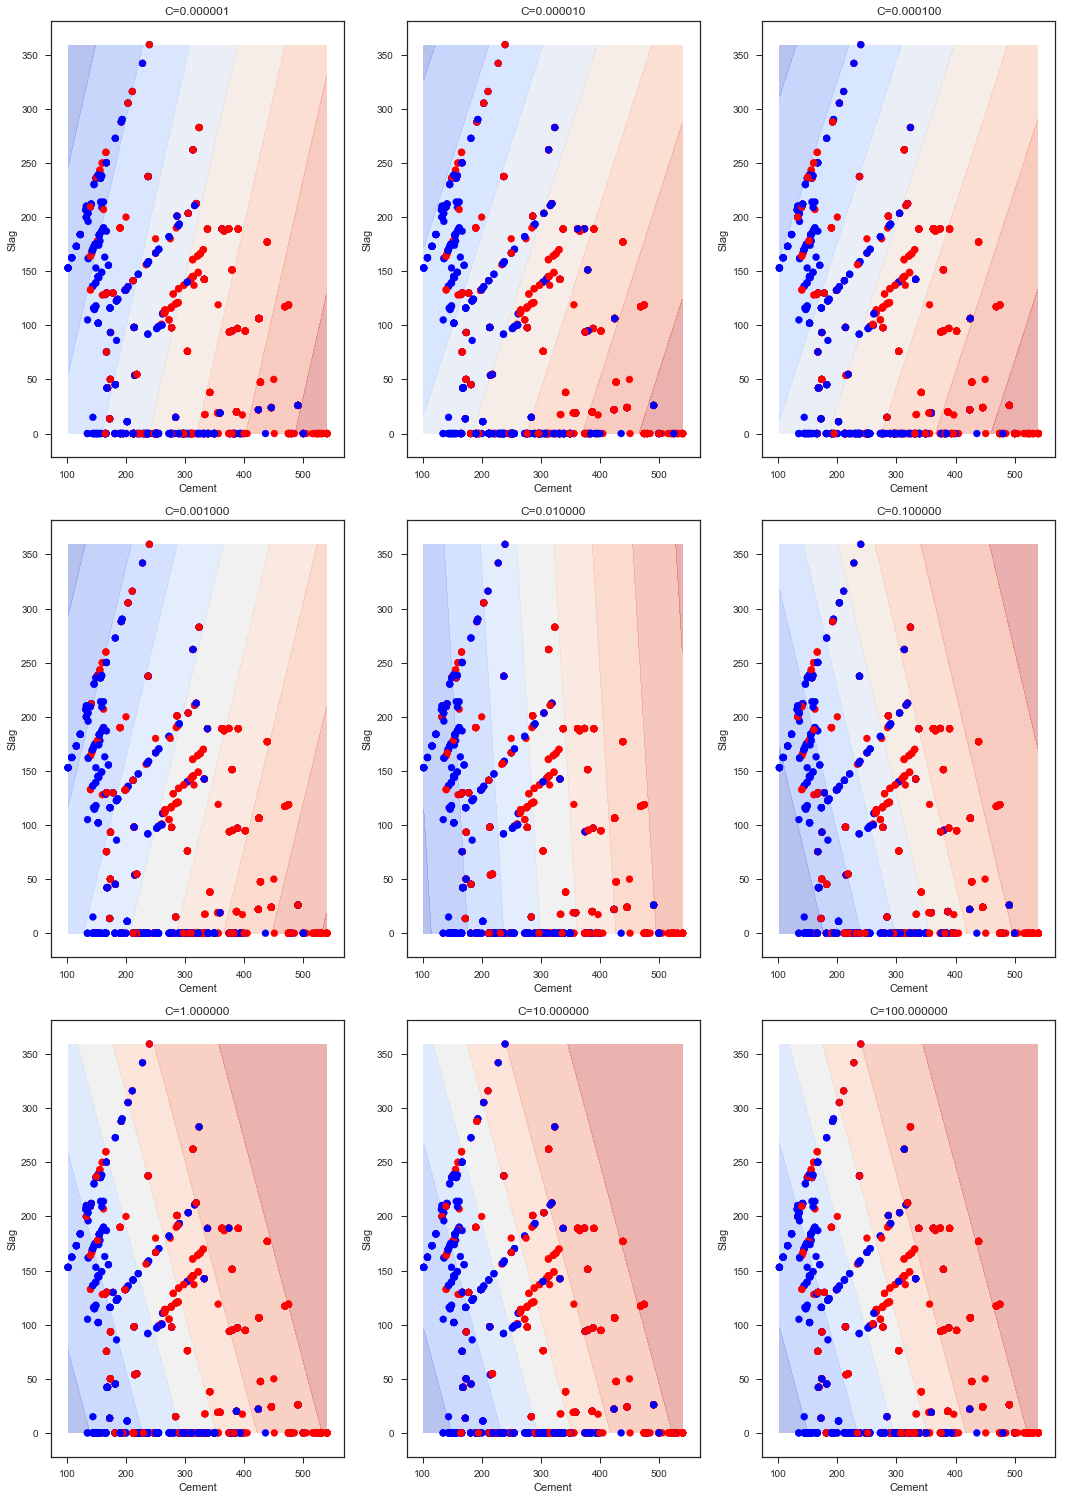


Fitting with l1 regularization: 



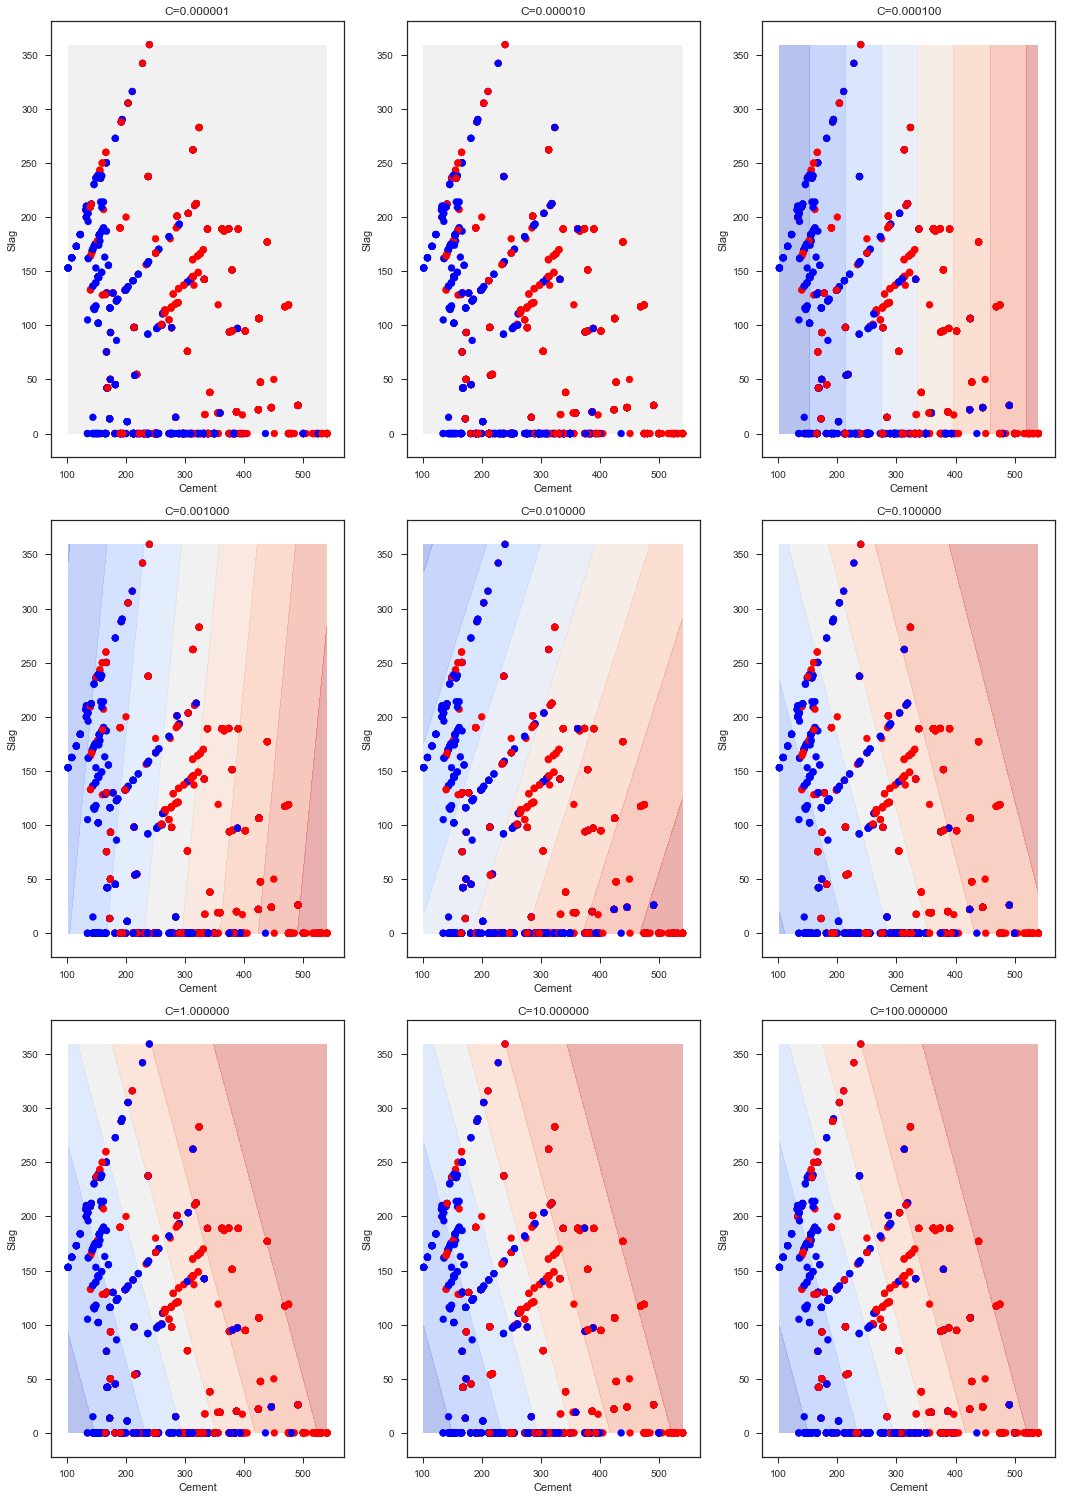

In [16]:
from sklearn.linear_model import LogisticRegression

# Plot different regularization values for L1 and L2 regularization
for regularization in ['l2', 'l1']:
    
    # Print what we are doing
    print ("\nFitting with %s regularization: \n" % regularization)
    position = 0

    plt.figure(figsize=[15, 21])
    c_values = [np.power(10.0, c) for c in range(-6, 3)]
    for c in c_values:
        position += 1
        plt.subplot(3, 3, position)
        
        model = LogisticRegression(penalty=regularization, C=c)
        Decision_Surface(concrete_df[predictor_columns],
                         "Cement",
                         "Slag",
                         concrete_df["class"],
                         model,
                         probabilities=True,
                         sample=1)
        plt.title("C=%f" % c)
    plt.tight_layout()
    plt.show()

### Feature's coefficient weights with L1/L2  and normalization

Let's take a look to the different values of our weights with each type of penalty but first, let's understand **normalization**. 

What is normalization? Why do we need normalization? Each time we work with data, it is very important to consider the "scale" of the features. Some features might have distinct values from 1 to 1000, and other features might have values from 0 to 1. As many different data science/machine learning methods compare data along different dimensions, it can often be important to make sure the dimensions are comparable.

To do this re-scaling there are are many approaches, the most common being:

- _Normalization_ : we rescale our data so that the features have unit norms  
- _Standardization_ : we rescale our data acting as if each features is normally distributed (Gaussian with zero mean and unit variance)
- _Scaling to a range_ : we rescale our data based on the minimum and maximum value of each feature 


( sklearn has a built-in function to help us re-scaling our data -- see below)

**Let's take a look at the data before and after re-scaling.**

Before re-scaling:

In [17]:
concrete_df.head(5)

,Cement,Slag,Fly Ash,Water,Superplasticizer,Coarse Agg,Fine Agg,Age,Strength,class
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111,1
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366,1
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535,1
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780,1
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075,1


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
concrete_df[predictor_columns] = scaler.fit_transform(concrete_df[predictor_columns])

After re-scaling:

In [20]:
concrete_df.head(5)

,Cement,Slag,Fly Ash,Water,Superplasticizer,Coarse Agg,Fine Agg,Age,Strength,class
0,2.477918,-0.856886,-0.847132,-0.916663,-0.620225,0.863160,-1.217658,-0.279733,79.986111,1
1,2.477918,-0.856886,-0.847132,-0.916663,-0.620225,1.056170,-1.217658,-0.279733,61.887366,1
2,0.491443,0.795533,-0.847132,2.175367,-1.038944,-0.526514,-2.240913,3.553066,40.269535,1
3,0.491443,0.795533,-0.847132,2.175367,-1.038944,-0.526514,-2.240913,5.057677,41.052780,1
4,-0.790432,0.678414,-0.847132,0.488805,-1.038944,0.070531,0.647908,4.978487,44.296075,1


Before we try and delve into the impact regularization has on the coefficients logistic regression assigns to different features, let's investigate the coefficients before any regularization is performed

In [54]:
def get_lr_coeffs(df, lr, predictor_columns, class_column):
    lr.fit(df[predictor_columns], df[class_column])

    return dict(zip(predictor_columns, lr.coef_[0]))

coefs = get_lr_coeffs(concrete_df, LogisticRegression(), predictor_columns, "class")
pd.DataFrame([coefs])

,Age,Cement,Coarse Agg,Fine Agg,Fly Ash,Slag,Superplasticizer,Water
0,2.578877,1.642198,0.006418,-0.348806,0.461958,0.843948,0.5929,-0.638004


Now we can see how the model weights change with differing degrees of complexity control

In [56]:
def get_lr_regularization_paths(df, predictor_columns, class_column, regtype, reg_values):
    coefs = [get_lr_coeffs(concrete_df,
                          LogisticRegression(penalty=regtype, C=10**reg),
                          predictor_columns,
                          class_column)
             for reg in reg_values]

    df = pd.DataFrame(coefs)
    df["regularization"] = reg_values
    
    df.set_index("regularization", inplace=True)
    
    return df

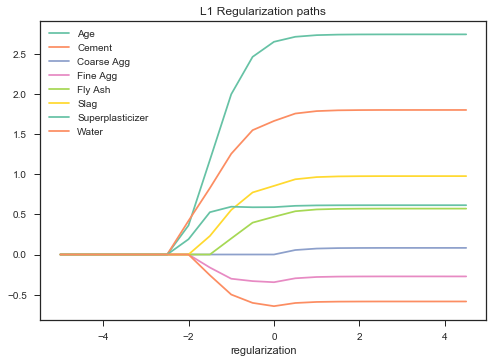

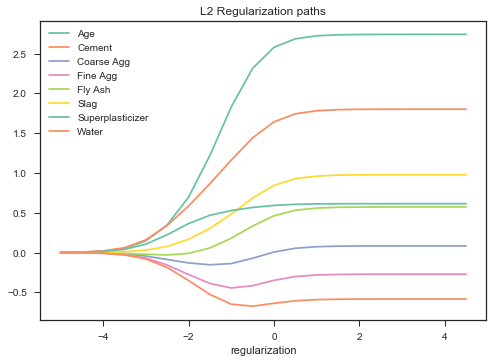

In [65]:
regs = np.arange(-5, 5, 0.5)  #go through a bunch of ascending regularization parameters
    
l1_coefs = get_lr_regularization_paths(concrete_df,
                                       predictor_columns,
                                       "class",
                                       "l1",
                                       regs)

l2_coefs = get_lr_regularization_paths(concrete_df,
                                       predictor_columns,
                                       "class",
                                       "l2",
                                       regs)

l1_coefs.plot()
plt.title("L1 Regularization paths")

l2_coefs.plot()
plt.title("L2 Regularization paths")

plt.show()

## Learning Curves

(Briefly covered in the last class)

Throughout the past two lectures we analyzed and compared model accuracies using a unique **sample size** that was essentially fixed and determined by the size of the toy datasets we are considering. 

Very often we also want to assess the relationship between how much data we are using to train the models, and the generalization performance we achieve.  For example, do we have a good idea whether we should invest in acquiring more training data? The only way to answer this question is again, experiment with different sample sizes. The main way to do this assessment is via **_learning curves_**: analyze the change of the generalization performance (accuray on the holdout data, in this case) based on different sizes of the training set.

What would we expect to see? Holding everything else fixed, the generalization should be better with more training data, up until a certain point. Then, more data won't increase generalization performance.

In [85]:
import sklearn.model_selection as cv
from sklearn.metrics import accuracy_score


def evaluate_model_on_sample(df, model, predictor_cols, class_col, pct, scoring=accuracy_score):
    kf = cv.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    X = df[predictor_cols]
    y = df[class_col]
    
    for train_index, test_index in kf.split(X, y):  
        # only take a portion of the training
        sampled_indices = np.random.permutation(range(len(train_index)))[:int(pct*len(train_index))].tolist()
        np_train = np.array(train_index)
        to_get = np_train[sampled_indices]

        model.fit(X.loc[to_get], y[to_get])
        scores.append(scoring(y[test_index], model.predict(X.loc[test_index])))
        
    return np.mean(scores), np.std(scores)

In [86]:
pcts = np.linspace(0.01,1,100).tolist()
dt_scores = [evaluate_model_on_sample(concrete_df,
                                     DecisionTreeClassifier(),
                                     predictor_columns,
                                     "class",
                                     pct)
             for pct in pcts]

lr_scores = [evaluate_model_on_sample(concrete_df,
                                      LogisticRegression(),
                                      predictor_columns,
                                      "class",
                                      pct)
             for pct in pcts]

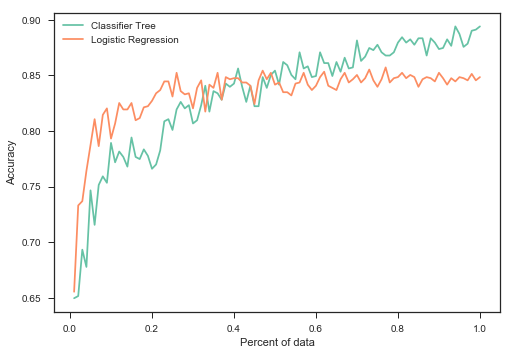

In [89]:
raw_dt_score = np.array([s[0] for s in dt_scores])
std_dt_score = np.array([s[1] for s in dt_scores])

raw_lr_score = np.array([s[0] for s in lr_scores])
std_lr_score = np.array([s[1] for s in lr_scores])



plt.plot(pcts, raw_dt_score, label="Classifier Tree")
plt.plot(pcts, raw_lr_score, label="Logistic Regression")
plt.xlabel("Percent of data")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

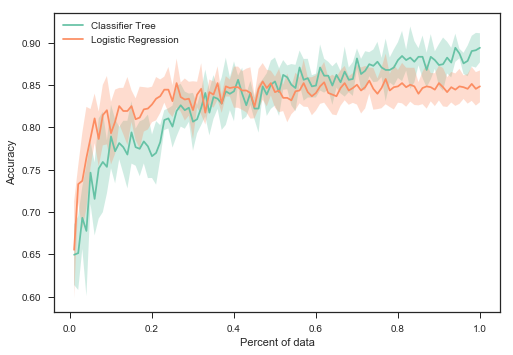

In [91]:
plt.plot(pcts, raw_dt_score, label="Classifier Tree")
plt.fill_between(pcts, raw_dt_score + std_dt_score, raw_dt_score - std_dt_score, alpha=0.3)
plt.plot(pcts, raw_lr_score, label="Logistic Regression")
plt.fill_between(pcts, raw_lr_score + std_lr_score, raw_lr_score - std_lr_score, alpha=0.3)
plt.xlabel("Percent of data")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Thus, learning curves will help to determine at least 2 things:

- We can see which model performs better or worse for each sample size (e.g. Decision Tree vs Logistic Regression)
- We can get a sense of whether getting more data (or using less) will improve (or not degrade) generalization.

We can also think of ways to add more complexity to a predictive model. Here, we build a model that considers polynomial combinations of features (as in our last class).